### Imports

In [1]:
import sys
import json
import matplotlib.pyplot as plt

### Local imports

In [2]:
sys.path.insert(0,'src/')
from src.metrics import BinaryClassificationResult
from src.print_util import print_rates

### Functions

In [3]:
# Get the results of a single experiment, summed over the reruns and the configurations
def get_results_non_federated(all_results):
    for configuration, configuration_results in all_results.items():      
        result = BinaryClassificationResult()
        # Run can be a random rerun (when testing) or a fold (when grid searching)
        for run, run_result in enumerate(configuration_results):
            result += BinaryClassificationResult(*run_result.values())
                
    return result

In [4]:
# Get the results for each federation round of a single experiment, summed over the reruns and the configurations
def get_results_per_round(all_results):
    results_per_round = []
    for configuration, configuration_results in all_results.items():      
        # Run can be a random rerun (when testing) or a fold (when grid searching)
        for run, run_results in enumerate(configuration_results):
            for federation_round, round_results in enumerate(run_results):
                if federation_round >= len(results_per_round):
                    results_per_round.append(BinaryClassificationResult())  
                results_per_round[federation_round] += BinaryClassificationResult(*round_results.values())
                
    return results_per_round

In [5]:
def plot_federated_tpr_tnr(results_to_plot, title=''):
    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.set_xlabel('Federation round')

    color = 'blue'
    ax1.set_title(title)
    ax1.set_ylabel('TPR', color=color)
    ax1.plot([result.tpr() for result in results_to_plot], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.ticklabel_format(useOffset=False)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'red'
    ax2.set_ylabel('TNR', color=color)
    ax2.plot([result.tnr() for result in results_to_plot], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

In [6]:
def plot_federated_acc(results_to_plot, title=''):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_xlabel('Federation round')

    color = 'green'
    ax.set_title(title)
    ax.set_ylabel('Accuracy', color=color)
    ax.plot([result.acc() for result in results_to_plot], color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax.ticklabel_format(useOffset=False)
    plt.show()

### Non-federated

In [10]:
path_test = 'test_results/decentralized_autoencoder/run_0/'

with open(path_test + 'local_results.json') as json_file:
    test_local_results = json.load(json_file)
    
with open(path_test + 'new_devices_results.json') as json_file:
    test_new_results = json.load(json_file)
    
local_result = get_results_non_federated(test_local_results)
new_result = get_results_non_federated(test_new_results)
print('Local result:')
print_rates(local_result)
print()

print('New result:')
print_rates(new_result)

Local result:
TPR: 96.38% - TNR: 97.10% - Accuracy: 96.39% - Precision: 99.94% - F1-Score: 98.13%

New result:
TPR: 96.97% - TNR: 48.55% - Accuracy: 95.86% - Precision: 98.77% - F1-Score: 97.86%


### Federated

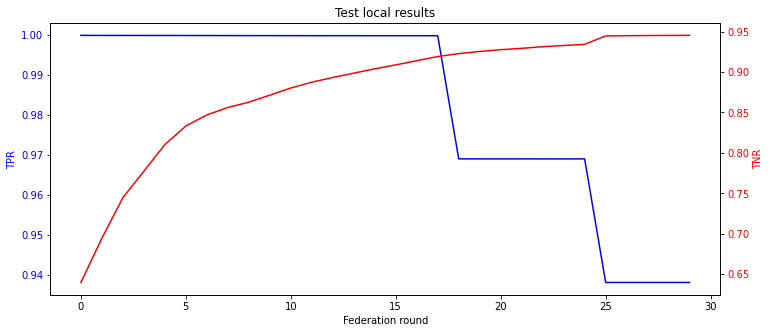

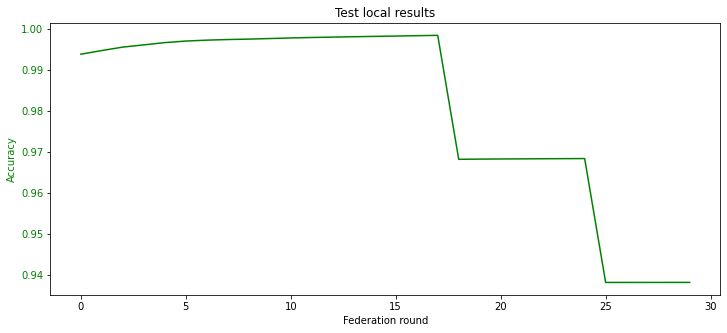

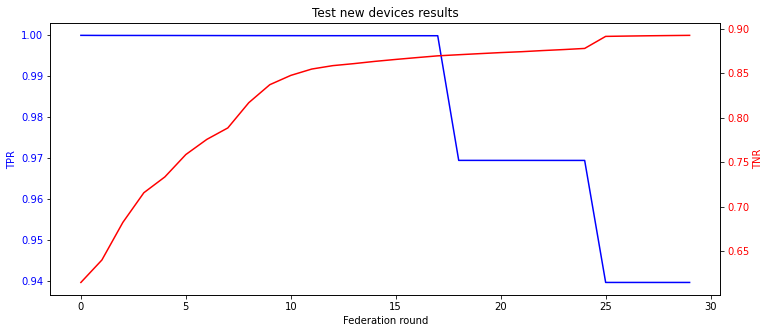

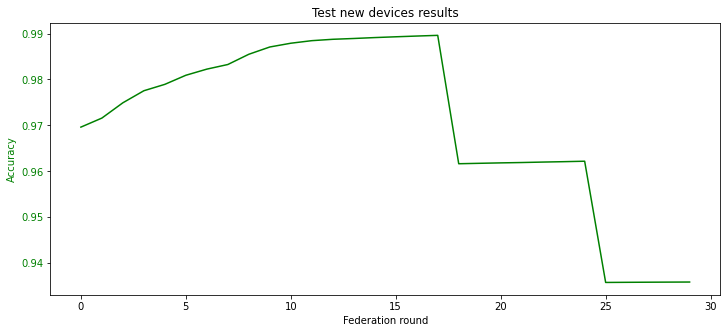

Local result at last round:
TPR: 93.80% - TNR: 94.54% - Accuracy: 93.82% - Precision: 99.90% - F1-Score: 96.76%

New result at last round:
TPR: 93.96% - TNR: 89.27% - Accuracy: 93.59% - Precision: 99.03% - F1-Score: 96.43%


In [11]:
path_test = 'test_results/decentralized_autoencoder_federated/run_1 (msi)/'

with open(path_test + 'local_results.json') as json_file:
    test_local_results = json.load(json_file)
    
with open(path_test + 'new_devices_results.json') as json_file:
    test_new_results = json.load(json_file)
    
local_results_per_round = get_results_per_round(test_local_results)
plot_federated_tpr_tnr(local_results_per_round, title='Test local results')
plot_federated_acc(local_results_per_round, title='Test local results')

new_results_per_round = get_results_per_round(test_new_results)
plot_federated_tpr_tnr(new_results_per_round, title='Test new devices results')
plot_federated_acc(new_results_per_round, title='Test new devices results')

print('Local result at last round:')
print_rates(local_results_per_round[-1])
print()

print('New result at last round:')
print_rates(new_results_per_round[-1])

These plots are interesting but could be improved with confidence intervals.